In [1]:
import nltk
import spacy
import re
import unidecode
from nltk.corpus import stopwords
from numpy import *
import pandas as pd 
import requests 
import re
import pdfplumber
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from collections import defaultdict
import pyLDAvis.gensim_models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.lda_model
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


In [2]:
nltk.download('stopwords')
greek_stopwords = set(stopwords.words('greek'))
nlp = spacy.load('el_core_news_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
greek_stopwords.update({
    "ο", "η", "το", "οι", "τα", "της", "του", "των", "τον", "την", "τους", "τις",
    "ένας", "μια", "ένα", "μερικοί", "μερικές", "μερικά",
    "αυτός", "αυτή", "αυτό", "αυτοί", "αυτές", "αυτά",
    "εκείνος", "εκείνη", "εκείνο", "εκείνοι", "εκείνες", "εκείνα",
    "εγώ", "εσύ", "αυτός", "αυτή", "αυτό", "εμείς", "εσείς", "αυτοί", "αυτές", "αυτά",
    "μου", "σου", "του", "της", "μας", "σας", "τους","με", "χωρίς", "για", "από", "σε", "προς", "μετά", "πριν", "κατά", "πάνω", "κάτω",
    "μέσα", "έξω", "δίπλα", "ανάμεσα", "αντί", "μαζί", "παρά", "όπως", "ώστε", "ενώ",
    "επειδή", "αν", "όταν", "που", "πως", "πότε", "όσο", "όπου", "διότι", "μήπως","είμαι", "είσαι", "είναι", "είμαστε", "είστε", "είναι",
    "έχω", "έχεις", "έχει", "έχουμε", "έχετε", "έχουν",
    "γίνομαι", "γίνεσαι", "γίνεται", "γινόμαστε", "γίνεστε", "γίνονται",
    "μπορώ", "μπορείς", "μπορεί", "μπορούμε", "μπορείτε", "μπορούν",
    "πρέπει", "θέλω", "ξέρω", "κάνω", "λέω", "βλέπω", "πάω", "έρχομαι", "πολύ", "λίγο", "σχεδόν", "ακριβώς", "πιθανόν", "ίσως", "βέβαια",
    "όχι", "ναι", "μάλλον", "κάπως", "αμέσως", "συνήθως", "πιθανώς",
    "πάντα", "ποτέ", "σήμερα", "αύριο", "χθες", "πριν", "μετά", "αργότερα", "όλα", "όλοι", "κάθε", "κάποιος", "κάποια", "κάποιο", "κανένας", "καμία", "κανένα", "δεν", "μήν", "μη", "οτιδήποτε", "οποιοσδήποτε", "οποιαδήποτε", "οποιοδήποτε",
    "όμως", "ωστόσο", "εντούτοις", "παρόλα", "ωσάν", "σαν", "ίσια", "μάλιστα",
    "ακόμα", "ακόμη", "μόνο", "απλώς", "ακριβώς", "σχετικά", "συγκεκριμένα"
    "τίποτα", "κάτι", "μερικοί", "μερικές", "μερικά", "αρκετά", "λίγα", "πολλά"
})

In [4]:
def preprocess_text(text):
    text = re.sub(r"[^α-ωΑ-Ωάέήίόύώϊϋΐΰ\s]", "", text)

    text = text.lower()
    
    sentences = text.split('\n')
    
    tokenized_sentences = []

    for sentence in sentences:
        doc = nlp(sentence)
        
        tokens = [str(token.lemma_) for token in doc if token.text not in greek_stopwords and not token.is_punct]
        
        tokens = [token for token in tokens if len(token) > 2]

        if tokens:
            tokenized_sentences.append(tokens)
    return tokenized_sentences


Let us create a list of books , upon which we will train our model.

In [5]:
books = ['https://1oholargou.wordpress.com/wp-content/uploads/2012/08/13078091-31328.pdf',
        'https://derkamerad.com/wp-content/uploads/2016/09/cebcceb1cf84cf89cebcceb5cebdceb1-cf87cf89cebcceb1cf84ceb1-ceb4ceb9ceb4cf89-cf83cf89cf84ceb7cf81ceb9cebfcf85.pdf',
          'https://schoolpress.sch.gr/periodista/files/2022/02/%CE%A4%CE%BF-%CE%9C%CE%BF%CE%BD%CF%8C%CE%B3%CF%81%CE%B1%CE%BC%CE%BC%CE%B11.pdf',
          'http://7gym-athin.att.sch.gr/wordpress/wp-content/uploads/2020/03/Aiolike-Ge-Elias-Benezes.pdf',
          'https://books.shopflix.gr/9786180103106.pdf',
          'https://www.patakis.gr/files/1187291.pdf',
          'https://manifestolibrary.noblogs.org/files/2020/10/441339144-%CE%86%CF%81%CE%B7%CF%82-%CE%91%CE%BB%CE%B5%CE%BE%CE%AC%CE%BD%CE%B4%CF%81%CE%BF%CF%85-%CF%84%CE%BF-%CE%BA%CE%B9%CE%B2%CF%8E%CF%84%CE%B9%CE%BF-pdf.pdf',
         #'https://www.xn--ixauk7au.gr/%CE%B4%CF%89%CF%81%CE%B5%CE%AC%CE%BD-ebooks/Alexandros_Papadiamandis-I_Fonissa.pdf' #doesnt work
         'https://esperos-library.ucoz.com/_ld/1/177_psathas.pdf',
         'https://archeia.moec.gov.cy/sm/371/diig_vizyinou_odig_ekpaid.pdf' #this works
         #'https://blogs.sch.gr/idaragiannis/files/2017/02/ena-paidi-metraei-t-astra.pdf' #doesnt work
 ]

In [6]:
def download_book(book, i):
    
    response = requests.get(book)
    pdf_path = f"{i}.pdf"
    with open(pdf_path, "wb") as f:
        f.write(response.content)
        
    #save the pdf as a string
    with pdfplumber.open(pdf_path) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text() + "\n"  
    return text

Download our books, save them as pdfs, convert them to strings, tokenize them, and add them to our corpus.

In [7]:
all_tokens = []
corpus = []
for i,book in enumerate(books):
    book_text = download_book(book, i)
    tokens = preprocess_text(book_text)
    book_text_processed = " ".join(word for sentence in tokens for word in sentence)
    corpus.append(book_text_processed)
    all_tokens.extend(tokens)

In [8]:
print(all_tokens)

[['ηλιο', 'βενεζη'], ['ακαδημία', 'αθηνών'], ['νούμερο'], ['βιβλιο', 'σκλαβια'], ['εισαγωγή', 'δημήτρης', 'δασκαλόπουλος'], ['τεσσαρακοστος', 'εβδομος', 'εκδοση'], ['βιβλιοπωλειον', 'εστια'], ['κολλαρο', 'σιος'], ['αθηνα'], ['νούμερο', 'ίδιος', 'ταυτότητα', 'συγγραφέα', 'παιδί'], ['δεκαοκτώς', 'χρόνος', 'οδηγώ', 'τούρκους', 'σε ο', 'κάτεργα', 'ανατολή'], ['βιβλίο', 'συγκλονιστικός', 'χρονικός', 'γραμμένος', 'αίμα', 'επισημαίνω'], ['βενέζης', 'προσθέτοντα', 'καυτής', 'ύλη', 'σάρκα', 'στάζω'], ['αίμα', 'πλημμυρίζω', 'σελίδα', 'αρχικός', 'μορφή', 'γράφτηκε'], ['ξαναδουλεύτηκε', 'οπότε', 'εκδόθηκε', 'πρώτος', 'φορά', 'επιτυχία'], ['σημείωσε', 'είμαι', 'τεράστιος', 'ελληνικός', 'χώρος'], ['ηλία', 'βενέζης', 'βιβλίομαρτυρία', 'γραώνμ', 'πρώτος', 'πρόσωπος'], ['πραγματικός', 'όνομα', 'αφηγητήσυγγραφέα', 'γεννήθηκε', 'αϊβαλί', 'ρθε'], ['Ελλάδα', 'μικρασιατικός', 'καταστροφή', 'θεωρώ'], ['κυριότερους', 'εκπροσώπους', 'γενιά', 'νεοελληνικός', 'πεζογραφία'], ['τεσσαρακοστή', 'τρίτος', 'έκδοση', '

In [9]:
print(corpus)

['ηλιο βενεζη ακαδημία αθηνών νούμερο βιβλιο σκλαβια εισαγωγή δημήτρης δασκαλόπουλος τεσσαρακοστος εβδομος εκδοση βιβλιοπωλειον εστια κολλαρο σιος αθηνα νούμερο ίδιος ταυτότητα συγγραφέα παιδί δεκαοκτώς χρόνος οδηγώ τούρκους σε ο κάτεργα ανατολή βιβλίο συγκλονιστικός χρονικός γραμμένος αίμα επισημαίνω βενέζης προσθέτοντα καυτής ύλη σάρκα στάζω αίμα πλημμυρίζω σελίδα αρχικός μορφή γράφτηκε ξαναδουλεύτηκε οπότε εκδόθηκε πρώτος φορά επιτυχία σημείωσε είμαι τεράστιος ελληνικός χώρος ηλία βενέζης βιβλίομαρτυρία γραώνμ πρώτος πρόσωπος πραγματικός όνομα αφηγητήσυγγραφέα γεννήθηκε αϊβαλί ρθε Ελλάδα μικρασιατικός καταστροφή θεωρώ κυριότερους εκπροσώπους γενιά νεοελληνικός πεζογραφία τεσσαρακοστή τρίτος έκδοση βιβλίου ηλία βενέζη νούμερο αναστοιχειοθετήθηκε προτάχθηκε αυτός εισαγωγικός κείμενο δημήτρη δασκαλόπουλου νέος έκδοση κυκλοφόρησε φεβρουάριο σειρά νεοελληνικός λογοτεχνία      τεσσαρακοστός έβδομος έκδοση σεπτέμβριος βιβλιοπωλειον εστια σσττηηνν ττυυρρααγγννιισσμμεεννηη μμηηττεερραα μμοου

Let us train a tf idf vectorizer on these sentences!

In [10]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()

word_tfidf = dict(zip(feature_names, tfidf_scores))

Check the words with the highest tf idf score, aka common words that are non distinctive!

In [11]:
print("top 100 words by tf-idf score:")
sorted_tfidf = sorted(word_tfidf.items(), key=lambda x: x[1], reverse=True)
for word, score in sorted_tfidf[:100]:
    print(word, score)

top 100 words by tf-idf score:
σε 0.19167148913386328
έχω 0.14079946661490034
άλλος 0.12498566338011846
είμαι 0.12491921421298875
ότι 0.08895208291521554
λέγω 0.07681495104237514
γιατί 0.06919528325987716
μεγάλος 0.06299230354952645
ένας 0.05716707423984563
πιο 0.05405440209101408
εκεί 0.053176297967952466
δυο 0.05308441698311487
λέει 0.05238483856531687
στός 0.052186058834901655
τώρα 0.05163772066267555
πού 0.050970012856592875
ώρα 0.05086532108950073
κάνω 0.048283771683162294
αλλά 0.048123259187809825
χέρι 0.04753621996814395
πρώτος 0.047237986463793784
ταν 0.04714709386309201
μάτι 0.046165389518195
μέρα 0.04596992938979575
οποίος 0.04426712629537223
ήτανε 0.0421614868966765
εις 0.041016713555408
ρτεμη 0.040562117317518416
έτσι 0.04024436374515771
όλος 0.04012032136838109
γιά 0.039493282197352104
ίδιος 0.0383580190519354
μικρός 0.037930950188979885
γίνομαι 0.037929680408716346
σαμαράκη 0.03756598916270645
βιζυηνός 0.03611558925600135
εκδοσεις 0.03596743643237852
ψυχογιος 0.0359674364

Define a function that filters words, based on their tf idf score, since we do not care about words that are all over our documents, because they are not distinctive in terms of our target word!

In [12]:
tfidf_threshold = np.percentile(list(word_tfidf.values()), 90)  # top 10% most common words

def filter_words_by_tfidf(similar_words, word_tfidf, threshold):
    return [(word, score) for word, score in similar_words if word_tfidf.get(word, 0) > threshold]

In [13]:
model = Word2Vec(all_tokens, vector_size=200, window=5, min_count=3, workers=8)

model.save("greek_word2vec.model")

In [14]:
word_index = model.wv.key_to_index.get('μαύρος', 'Word not found in vocabulary')

print(f"Index of '': {word_index}")

Index of '': 2329


In [15]:
vocab = model.wv.index_to_key
print(vocab[146]) 

αντάρτης


In [16]:
similar_words_woman = model.wv.most_similar('γυναίκα', topn=200)
similar_words_man = model.wv.most_similar('άντρας', topn=200)

Similar words to man, without tf idf

In [17]:
print("\nSimilar words to 'γυναίκα':")
for word in similar_words_woman:
    print(word)


Similar words to 'γυναίκα':
('νέος', 0.9998605251312256)
('μόλις', 0.9998595714569092)
('κορίτσι', 0.9998571276664734)
('τόπος', 0.999849259853363)
('καθώς', 0.9998475909233093)
('τσι', 0.9998467564582825)
('τούρκοι', 0.9998445510864258)
('εγώ', 0.9998432993888855)
('καλός', 0.9998388290405273)
('κόσμος', 0.9998348951339722)
('θέση', 0.9998347759246826)
('αφού', 0.9998339414596558)
('περιοχή', 0.9998339414596558)
('μεταξύ', 0.9998335242271423)
('αλέκος', 0.9998332262039185)
('παππός', 0.9998324513435364)
('σημείο', 0.9998317360877991)
('εδώ', 0.9998316168785095)
('νας', 0.9998315572738647)
('είδε', 0.9998314380645752)
('έργο', 0.9998306632041931)
('σκοπός', 0.9998301863670349)
('φαίνομαι', 0.9998296499252319)
('μόνος', 0.999829113483429)
('νεκρός', 0.99982750415802)
('απάνω', 0.9998271465301514)
('άντρας', 0.9998266100883484)
('ταξίδι', 0.9998260140419006)
('τότης', 0.9998257160186768)
('είδος', 0.9998254776000977)
('Ελλάδα', 0.9998252391815186)
('βρίσκω', 0.9998251795768738)
('μέχρι'

Similar words to man, without tf idf

In [18]:
print("\nSimilar words to 'άντρας':")
for word in similar_words_man:
    print(word)


Similar words to 'άντρας':
('νεκρός', 0.9998762607574463)
('πέντε', 0.9998757839202881)
('οπλαρχηγός', 0.9998695254325867)
('τότης', 0.9998679757118225)
('σημείο', 0.9998656511306763)
('ομάδα', 0.9998652935028076)
('δύο', 0.9998652935028076)
('σταμάτης', 0.9998648166656494)
('καθώς', 0.9998644590377808)
('αντάρτης', 0.9998639822006226)
('πήρε', 0.9998630285263062)
('ήσαν', 0.9998626708984375)
('κιόλας', 0.9998593926429749)
('ίσαμε', 0.9998587369918823)
('στρατιώτης', 0.9998574256896973)
('φτάνω', 0.9998571276664734)
('μέχρι', 0.9998566508293152)
('θέση', 0.9998562932014465)
('τούρκοι', 0.9998559355735779)
('νας', 0.9998556971549988)
('είδε', 0.9998542070388794)
('δουλειά', 0.9998536705970764)
('μένω', 0.9998534917831421)
('νέος', 0.9998531937599182)
('ταν', 0.9998531937599182)
('τσι', 0.9998518824577332)
('κορίτσι', 0.9998515248298645)
('μάχη', 0.9998506903648376)
('τόπος', 0.9998498558998108)
('σκοπός', 0.9998495578765869)
('βράδυ', 0.9998483061790466)
('πέρασε', 0.999847948551178)
(

Use tf idf for both groups, in order to filter non distinctive words (aka words that appear all over the book, and not just our target tokens)

In [19]:

similar_words_man_filtered = filter_words_by_tfidf(similar_words_man, word_tfidf, tfidf_threshold)
similar_words_woman_filtered = filter_words_by_tfidf(similar_words_woman, word_tfidf, tfidf_threshold)


In [20]:
def find_similar(word):
    similar_words = model.wv.most_similar(word, topn=1000)
    similar_words_filtered = filter_words_by_tfidf(similar_words, word_tfidf, tfidf_threshold)
    return similar_words, similar_words_filtered

In [21]:
print("\nFiltered similar words to 'γυναίκα':")
for word, score in similar_words_woman_filtered:
    print(word, score)


Filtered similar words to 'γυναίκα':
νέος 0.9998605251312256
μόλις 0.9998595714569092
κορίτσι 0.9998571276664734
τόπος 0.999849259853363
καθώς 0.9998475909233093
τσι 0.9998467564582825
τούρκοι 0.9998445510864258
εγώ 0.9998432993888855
καλός 0.9998388290405273
κόσμος 0.9998348951339722
θέση 0.9998347759246826
αφού 0.9998339414596558
περιοχή 0.9998339414596558
μεταξύ 0.9998335242271423
αλέκος 0.9998332262039185
παππός 0.9998324513435364
σημείο 0.9998317360877991
εδώ 0.9998316168785095
νας 0.9998315572738647
είδε 0.9998314380645752
έργο 0.9998306632041931
σκοπός 0.9998301863670349
φαίνομαι 0.9998296499252319
μόνος 0.999829113483429
νεκρός 0.99982750415802
απάνω 0.9998271465301514
άντρας 0.9998266100883484
ταξίδι 0.9998260140419006
τότης 0.9998257160186768
είδος 0.9998254776000977
βρίσκω 0.9998251795768738
μέχρι 0.999825119972229
όνομα 0.9998250603675842
φωτιά 0.9998248815536499
όσος 0.9998247027397156
προσπάθεια 0.999824583530426
ύστερα 0.9998244047164917
παππού 0.9998242259025574
χαρά 0

In [22]:
print("\nFiltered similar words to 'άνδρας':")
for word, score in similar_words_man_filtered:
    print(word, score)


Filtered similar words to 'άνδρας':
νεκρός 0.9998762607574463
πέντε 0.9998757839202881
οπλαρχηγός 0.9998695254325867
τότης 0.9998679757118225
σημείο 0.9998656511306763
ομάδα 0.9998652935028076
δύο 0.9998652935028076
σταμάτης 0.9998648166656494
καθώς 0.9998644590377808
αντάρτης 0.9998639822006226
πήρε 0.9998630285263062
ήσαν 0.9998626708984375
κιόλας 0.9998593926429749
ίσαμε 0.9998587369918823
στρατιώτης 0.9998574256896973
φτάνω 0.9998571276664734
μέχρι 0.9998566508293152
θέση 0.9998562932014465
τούρκοι 0.9998559355735779
νας 0.9998556971549988
είδε 0.9998542070388794
δουλειά 0.9998536705970764
μένω 0.9998534917831421
νέος 0.9998531937599182
ταν 0.9998531937599182
τσι 0.9998518824577332
κορίτσι 0.9998515248298645
μάχη 0.9998506903648376
τόπος 0.9998498558998108
σκοπός 0.9998495578765869
βράδυ 0.9998483061790466
πέρασε 0.999847948551178
διαταγή 0.9998478889465332
δείχνω 0.9998477697372437
ύστερα 0.9998477101325989
αφού 0.9998475313186646
ζητώ 0.9998471140861511
αφήνω 0.9998470544815063


In [23]:
similar_words_black = model.wv.most_similar('μαύρος', topn=500)
similar_words_black_filtered = filter_words_by_tfidf(similar_words_black, word_tfidf, tfidf_threshold)
for w in similar_words_black_filtered:
    print(w)

('πρόσωπος', 0.9991198778152466)
('κύμα', 0.9991037845611572)
('αγώνας', 0.9991027116775513)
('γραμμή', 0.9991008043289185)
('θάνατος', 0.9990992546081543)
('φαίνομαι', 0.9990887641906738)
('κάποτε', 0.9990881085395813)
('σπίτι', 0.9990877509117126)
('αντάρτης', 0.9990873336791992)
('ανατολή', 0.9990835189819336)
('επάνω', 0.9990829229354858)
('μέσος', 0.9990813136100769)
('όξω', 0.9990806579589844)
('μονοπάτι', 0.9990788102149963)
('βάζω', 0.9990776777267456)
('τραπεζούντα', 0.9990771412849426)
('καθώς', 0.9990768432617188)
('ναός', 0.9990746378898621)
('αφηγητής', 0.9990734457969666)
('χρόνος', 0.999072253704071)
('αμισού', 0.9990714192390442)
('ξένος', 0.9990705847740173)
('προσπαθώ', 0.9990701079368591)
('τέλος', 0.9990694522857666)
('κρατώ', 0.9990693926811218)
('νεκρός', 0.9990659356117249)
('παλικάριο', 0.9990642666816711)
('στάθηκε', 0.9990631341934204)
('έπεσε', 0.9990630745887756)
('μέχρι', 0.9990624785423279)
('δωμάτιος', 0.9990622997283936)
('απότομα', 0.9990621209144592)
(

In [24]:
print(corpus[4])

εκδοσεις ψυχογιος τατοου     μεταμορφωση αττικη τηλ               σησχημ σελ ράχη χαρτί παλατινα βιβλς ηλιοπουλοσροδοπουλοςς αληθινό αριστούργημα ιδιοφυα δύναμη φαντασία έξοχος τεχνικός αντώνη σαμαράκης δίνω ψυχολογικός πάλη δύο πράκτος μυστικός υπηρεσία ασφάλεια ένας ολος κληρωτικός καθεστώς ύποπτος καθεστώς τέλειος μηχανισμός εξόντωση ανθρώπου πλο πρά συλλαμβάνω ζούμε ηθοποιοί θέατρο κτορα ασφάλεια αμείλικτα τετράγωνη λογικός πλο επίσης παραλόγος λόγος τόσο επίμονη διάκριση οπαδός εχθρός θαυμάζω λαθος γιατί δύναμη αναλύω παράλογος ζούμε αίσθος πολίτης ύποπτος συνωμοσία ενάντια καθεστώς βγει χιούμορ ποίηση βάθος μέση αφού μόνος μάρτυρα κατηγορία υπεράσπιση δολοφονημένος αντωνης σαμαρακη αποφοίτησε νομικός σχολή πανεπιστήμιο αθηνών δούλε ίδιος πράκτορος τίθεται εφαρμογή σχέδιο πολίτης αντιμε χρόνος υπουργείο εργασία τωπίζω δήθενς φιλικός ανθρώπινος συμπεριφορά σπάω αποδράζω παραιτήθηκε εκπρόσωπος Ελλάδα συγκλονιστικός εύχομαι δια μεταφορά ανάκριση προκειμένου αποδειχθεί ενοχή ηνωμένος 

In [25]:
for w in all_tokens:
    print(w)

['ηλιο', 'βενεζη']
['ακαδημία', 'αθηνών']
['νούμερο']
['βιβλιο', 'σκλαβια']
['εισαγωγή', 'δημήτρης', 'δασκαλόπουλος']
['τεσσαρακοστος', 'εβδομος', 'εκδοση']
['βιβλιοπωλειον', 'εστια']
['κολλαρο', 'σιος']
['αθηνα']
['νούμερο', 'ίδιος', 'ταυτότητα', 'συγγραφέα', 'παιδί']
['δεκαοκτώς', 'χρόνος', 'οδηγώ', 'τούρκους', 'σε ο', 'κάτεργα', 'ανατολή']
['βιβλίο', 'συγκλονιστικός', 'χρονικός', 'γραμμένος', 'αίμα', 'επισημαίνω']
['βενέζης', 'προσθέτοντα', 'καυτής', 'ύλη', 'σάρκα', 'στάζω']
['αίμα', 'πλημμυρίζω', 'σελίδα', 'αρχικός', 'μορφή', 'γράφτηκε']
['ξαναδουλεύτηκε', 'οπότε', 'εκδόθηκε', 'πρώτος', 'φορά', 'επιτυχία']
['σημείωσε', 'είμαι', 'τεράστιος', 'ελληνικός', 'χώρος']
['ηλία', 'βενέζης', 'βιβλίομαρτυρία', 'γραώνμ', 'πρώτος', 'πρόσωπος']
['πραγματικός', 'όνομα', 'αφηγητήσυγγραφέα', 'γεννήθηκε', 'αϊβαλί', 'ρθε']
['Ελλάδα', 'μικρασιατικός', 'καταστροφή', 'θεωρώ']
['κυριότερους', 'εκπροσώπους', 'γενιά', 'νεοελληνικός', 'πεζογραφία']
['τεσσαρακοστή', 'τρίτος', 'έκδοση', 'βιβλίου', 'ηλία', 'βε

Let us check the differences between men and women better

In [26]:
woman = set(similar_words_woman_filtered) - set(similar_words_man_filtered)
for c in woman:
    print(c)

('προσπάθεια', 0.999824583530426)
('παίρνω', 0.9997929334640503)
('νερό', 0.9998005628585815)
('τόπος', 0.999849259853363)
('ελλήνος', 0.9997859001159668)
('στόμα', 0.9997894167900085)
('περιμένω', 0.9997966885566711)
('μέχρι', 0.999825119972229)
('σημείο', 0.9998317360877991)
('τέτοιος', 0.9998220801353455)
('αφήγηση', 0.9998202323913574)
('αγά', 0.9997890591621399)
('γυναικόπαιδα', 0.9998055100440979)
('φύλλο', 0.9998129606246948)
('καθένας', 0.9997950792312622)
('τελικά', 0.999812662601471)
('κόκκινος', 0.9998065233230591)
('πέφτω', 0.9997868537902832)
('μήνυμα', 0.9997888803482056)
('αρχή', 0.9998182058334351)
('πράγματι', 0.9998095035552979)
('σταμάτης', 0.999799907207489)
('πατέρα', 0.9997926354408264)
('τότης', 0.9998257160186768)
('κοντά', 0.9998090863227844)
('βράδυ', 0.9998034834861755)
('μονάχα', 0.9998213052749634)
('αγέρα', 0.9997904300689697)
('ξένος', 0.9997939467430115)
('έπεσε', 0.9997873902320862)
('γιαγιά', 0.9998015761375427)
('μέτρο', 0.9998001456260681)
('βουνός',

In [27]:
man = set(similar_words_man_filtered) - set(similar_words_woman_filtered)
for c in man:
    print(c)

('καιρός', 0.9998158812522888)
('μέσος', 0.9998126029968262)
('μένω', 0.9998534917831421)
('έπιασε', 0.9998067617416382)
('τέσσερις', 0.9998382329940796)
('ιστορία', 0.9998335838317871)
('φαίνομαι', 0.999825119972229)
('σκέψη', 0.9998146891593933)
('εκείνος', 0.9998062252998352)
('κιβώτιος', 0.9998245239257812)
('ανάγκη', 0.9998153448104858)
('εποχή', 0.9998115301132202)
('αποστολή', 0.9998087286949158)
('συνεχίζω', 0.9998291730880737)
('σημείο', 0.9998656511306763)
('μήνας', 0.9998154640197754)
('τσι', 0.9998518824577332)
('μέρος', 0.9998241662979126)
('μονάχα', 0.9998331665992737)
('χώμα', 0.9998208284378052)
('ταξίδι', 0.9998394846916199)
('τέτοιος', 0.9998460412025452)
('πόλη', 0.9998255968093872)
('νέος', 0.9998531937599182)
('ελληνικός', 0.9998051524162292)
('στρατός', 0.9998050332069397)
('καθένας', 0.9998056888580322)
('πρόσωπο', 0.999810516834259)
('προσπάθεια', 0.9998171925544739)
('άλλον', 0.9998049736022949)
('φωτιά', 0.9998238682746887)
('νας', 0.9998556971549988)
('λοιπόν

Count occurances

In [28]:
words_to_count = ['γυναίκα', 'άντρας']

word_counts = {word: sum([sentence.count(word) for sentence in all_tokens]) for word in words_to_count}

# Print the results
for word, count in word_counts.items():
    print(f"The word '{word}' appears {count} times in the corpus.")


The word 'γυναίκα' appears 302 times in the corpus.
The word 'άντρας' appears 222 times in the corpus.


In [29]:
words_to_count = ['κορίτσι', 'αγόρι']

word_counts = {word: sum([sentence.count(word) for sentence in all_tokens]) for word in words_to_count}

for word, count in word_counts.items():
    print(f"The word '{word}' appears {count} times in the corpus.")


The word 'κορίτσι' appears 109 times in the corpus.
The word 'αγόρι' appears 38 times in the corpus.


In [30]:
girl, girl_filtered = find_similar('κορίτσι')
for c in girl_filtered:
    print(c)

('τούρκοι', 0.9998947978019714)
('τόπος', 0.9998853802680969)
('μόλις', 0.9998823404312134)
('αφού', 0.9998818039894104)
('χώρα', 0.9998800754547119)
('σάντα', 0.9998781085014343)
('ολόκληρος', 0.9998718500137329)
('μεταξύ', 0.9998713135719299)
('νας', 0.9998709559440613)
('είδε', 0.9998701810836792)
('τσι', 0.9998686909675598)
('αλέκος', 0.9998685717582703)
('έργο', 0.9998682737350464)
('καθώς', 0.9998681545257568)
('τρέχω', 0.99986732006073)
('βρίσκω', 0.9998672008514404)
('κάποτε', 0.9998670816421509)
('απάνω', 0.9998665452003479)
('καρδιά', 0.9998661279678345)
('πορεία', 0.9998650550842285)
('μέχρι', 0.9998642206192017)
('εδώ', 0.9998635649681091)
('πήγε', 0.9998632669448853)
('άλογος', 0.9998629689216614)
('τελικά', 0.999862551689148)
('μονάχα', 0.9998623728752136)
('αξιωματικός', 0.9998617172241211)
('αφήνω', 0.999861478805542)
('θάλασσα', 0.9998612999916077)
('θέση', 0.9998610019683838)
('πράγματι', 0.9998608231544495)
('είδα', 0.9998607039451599)
('οπλαρχηγός', 0.99986004829406

Can the model consider women as queens ?

In [31]:
result = model.wv.most_similar(positive=['γυναίκα', 'βασιλιάς'], negative=['άνδρας'], topn=5)
print("Analogy result:", result)


Analogy result: [('έτοιμος', 0.9920766949653625), ('λένος', 0.9920322299003601), ('είπα', 0.9920014142990112), ('έλεγε', 0.9919965267181396), ('έστω', 0.991993248462677)]


In [32]:
len(all_tokens)

38462

In [33]:
similarity = model.wv.similarity('άνδρας', 'γυναίκα')
print(f"man woman similarity: {similarity}")

print(model.wv.similarity('πατέρας', 'μητέρα'))
print(model.wv.similarity('αγόρι', 'κορίτσι'))

man woman similarity: 0.9970687031745911
0.99946594
0.99966645


Is one gender more likely to have an established career ?

In [34]:
professions = ['γιατρός', 'μηχανικός', 'δικηγόρος',  'καθηγητής']

for profession in professions:
    sim_man = model.wv.similarity('άνδρας', profession)
    sim_woman = model.wv.similarity('γυναίκα', profession)
    print(f"{profession}: άνδρας ({sim_man:.2f}) vs. γυναίκα ({sim_woman:.2f})")


γιατρός: άνδρας (1.00) vs. γυναίκα (1.00)
μηχανικός: άνδρας (0.99) vs. γυναίκα (1.00)
δικηγόρος: άνδρας (1.00) vs. γυναίκα (1.00)
καθηγητής: άνδρας (1.00) vs. γυναίκα (1.00)


In [35]:
greek_sim = model.wv.most_similar('ρωμιός', topn=40)
turk_sim = model.wv.most_similar('τούρκος', topn=40)
greek_filtered = filter_words_by_tfidf(greek_sim, word_tfidf, tfidf_threshold)

print("Words similar to 'Έλληνας':")
for greek in greek_filtered:
    print(greek)


Words similar to 'Έλληνας':
('ομάδα', 0.9996692538261414)
('μονάχα', 0.9996628761291504)
('τόπος', 0.9996588826179504)
('τότης', 0.9996587038040161)
('κάποτε', 0.9996552467346191)
('απάνω', 0.9996547698974609)
('κοντά', 0.9996530413627625)
('δικός', 0.9996529817581177)
('μέχρι', 0.9996528029441833)
('εκτός', 0.9996519088745117)
('αφήνω', 0.9996518492698669)
('ταξίδι', 0.9996515512466431)
('αντάρτης', 0.9996514916419983)
('σύντροφος', 0.9996482133865356)
('τούρκος', 0.9996477961540222)
('έργο', 0.999645471572876)
('οπλαρχηγός', 0.9996454119682312)
('δύναμη', 0.9996452331542969)
('ίσαμε', 0.9996449947357178)
('παίρνω', 0.9996448159217834)
('στρατιώτης', 0.9996446371078491)
('κόσμος', 0.9996443390846252)
('φωτιά', 0.9996426701545715)
('παππού', 0.9996426105499268)
('καθώς', 0.9996424317359924)
('λαός', 0.9996422529220581)
('βρίσκω', 0.9996412396430969)
('σπίτι', 0.999640941619873)
('άντρας', 0.999640703201294)
('σάντα', 0.9996399879455566)
('είδε', 0.9996382594108582)
('γύρω', 0.999637722

In [36]:
    
turk_sim_filtered = filter_words_by_tfidf(turk_sim, word_tfidf, tfidf_threshold)
print("Words similar to 'Τούρκος':")
for turk in turk_sim_filtered:
    print(turk)

Words similar to 'Τούρκος':
('καθώς', 0.9999164342880249)
('θέση', 0.9998975396156311)
('τούρκοι', 0.9998958110809326)
('πήρε', 0.9998934268951416)
('αντάρτης', 0.99989253282547)
('έργο', 0.9998923540115356)
('ελληνικός', 0.999891459941864)
('τόπος', 0.9998896718025208)
('τραπεζούντα', 0.9998888373374939)
('όσος', 0.9998887777328491)
('οπλαρχηγός', 0.9998885989189148)
('μόλις', 0.9998867511749268)
('ιστορία', 0.9998862147331238)
('τούτος', 0.9998860955238342)
('μέχρι', 0.9998860359191895)
('τότης', 0.9998859763145447)
('νεκρός', 0.999885082244873)
('μεταξύ', 0.9998844861984253)
('ανατολή', 0.9998838901519775)
('πέτρα', 0.9998835921287537)
('προσπαθώ', 0.9998832941055298)
('δείχνω', 0.9998827576637268)
('δύναμη', 0.9998816251754761)
('είδε', 0.9998815655708313)
('τούρκικος', 0.9998815059661865)
('ψυχή', 0.9998810887336731)
('αμισού', 0.9998804926872253)
('αφού', 0.9998799562454224)
('τρόπος', 0.999879002571106)
('καρδιά', 0.9998788833618164)
('απάνω', 0.9998788237571716)
('πάει', 0.9998

In [37]:
similar_black = model.wv.most_similar('μαύρος', topn=20)
similar_foreigner = model.wv.most_similar('ξένος', topn=20)

print("Words similar to 'μαύρος':", similar_black)
print("Words similar to 'ξένος':", similar_foreigner)

Words similar to 'μαύρος': [('πρόσωπος', 0.9991198778152466), ('κύμα', 0.9991037845611572), ('αγώνας', 0.9991027116775513), ('γραμμή', 0.9991008043289185), ('θάνατος', 0.9990992546081543), ('φαίνομαι', 0.9990887641906738), ('κάποτε', 0.9990881085395813), ('σπίτι', 0.9990877509117126), ('αντάρτης', 0.9990873336791992), ('ανατολή', 0.9990835189819336), ('επάνω', 0.9990829229354858), ('μέσος', 0.9990813136100769), ('όξω', 0.9990806579589844), ('μονοπάτι', 0.9990788102149963), ('βάζω', 0.9990776777267456), ('τραπεζούντα', 0.9990771412849426), ('καθώς', 0.9990768432617188), ('ναός', 0.9990746378898621), ('αφηγητής', 0.9990734457969666), ('χρόνος', 0.999072253704071)]
Words similar to 'ξένος': [('δίνω', 0.9998851418495178), ('τότης', 0.9998822808265686), ('ιστορία', 0.9998801350593567), ('μεταξύ', 0.9998799562454224), ('καρδιά', 0.9998794198036194), ('απάνω', 0.9998757839202881), ('μέχρι', 0.9998738169670105), ('είδε', 0.9998736381530762), ('τραπεζούντα', 0.9998732805252075), ('εποχή', 0.999

In [38]:
corpus = [doc for doc in corpus if doc.strip()]
corpus_joined = " ".join(corpus)


In [39]:
display(corpus)

['ηλιο βενεζη ακαδημία αθηνών νούμερο βιβλιο σκλαβια εισαγωγή δημήτρης δασκαλόπουλος τεσσαρακοστος εβδομος εκδοση βιβλιοπωλειον εστια κολλαρο σιος αθηνα νούμερο ίδιος ταυτότητα συγγραφέα παιδί δεκαοκτώς χρόνος οδηγώ τούρκους σε ο κάτεργα ανατολή βιβλίο συγκλονιστικός χρονικός γραμμένος αίμα επισημαίνω βενέζης προσθέτοντα καυτής ύλη σάρκα στάζω αίμα πλημμυρίζω σελίδα αρχικός μορφή γράφτηκε ξαναδουλεύτηκε οπότε εκδόθηκε πρώτος φορά επιτυχία σημείωσε είμαι τεράστιος ελληνικός χώρος ηλία βενέζης βιβλίομαρτυρία γραώνμ πρώτος πρόσωπος πραγματικός όνομα αφηγητήσυγγραφέα γεννήθηκε αϊβαλί ρθε Ελλάδα μικρασιατικός καταστροφή θεωρώ κυριότερους εκπροσώπους γενιά νεοελληνικός πεζογραφία τεσσαρακοστή τρίτος έκδοση βιβλίου ηλία βενέζη νούμερο αναστοιχειοθετήθηκε προτάχθηκε αυτός εισαγωγικός κείμενο δημήτρη δασκαλόπουλου νέος έκδοση κυκλοφόρησε φεβρουάριο σειρά νεοελληνικός λογοτεχνία      τεσσαρακοστός έβδομος έκδοση σεπτέμβριος βιβλιοπωλειον εστια σσττηηνν ττυυρρααγγννιισσμμεεννηη μμηηττεερραα μμοου

In [40]:
# For a corpus of 6 books:
tf_vectorizer = CountVectorizer(
    lowercase=True,
    max_df=0.85,       # Allow words present in ≤95% of documents (≤5.7 books → 5 books)
    min_df=2,          # Require words to appear in ≥2 books
    token_pattern=r'\b[\u0370-\u03FF]{3,}\b',  # Match Greek words with ≥3 letters
    stop_words=list(greek_stopwords)  # Use your Greek stopwords list
)

tf = tf_vectorizer.fit_transform(corpus)
print(tf.shape) 


(8, 10498)


In [58]:
n_topics = 8
print("Fitting LDA models with tf features, "
      f"n_samples={tf.shape[0]} and n_features={tf.shape[1]}...")
lda = LatentDirichletAllocation(n_components=8, 
                                learning_method='online',
                                random_state=0)
lda.fit(tf)


Fitting LDA models with tf features, n_samples=8 and n_features=10498...


LatentDirichletAllocation(learning_method='online', n_components=8,
                          random_state=0)

In [59]:
print(lda.components_.shape)
lda.components_

(8, 10498)


array([[ 1.88711566,  0.35541059,  0.49409753, ...,  0.85749785,
         1.09860566, 31.56984004],
       [ 0.30209346,  0.35572999,  0.28633973, ...,  0.37679162,
         0.31371051,  0.57396113],
       [ 1.09158759,  1.15111865, 12.55614944, ..., 18.16799011,
         1.71206898, 24.1202597 ],
       ...,
       [ 0.3329526 ,  0.32314034,  0.38905253, ...,  1.29697753,
         0.35756061,  0.60355533],
       [ 0.29819682,  0.37248147,  0.29674569, ...,  0.46952553,
         0.32293635,  0.49427589],
       [ 0.31938636,  7.27618767,  0.4166229 , ...,  1.22432199,
         1.82458175,  0.56565663]])

In [60]:
n_top_words = 30
print("Topics in the LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}")
    sorted_topics_indcs = (-topic).argsort()[:n_top_words]
    feature_names = [ tf_feature_names[i] for i in sorted_topics_indcs ]
    feature_counts = topic[sorted_topics_indcs]
    print(" ".join([ f'{fn} {fc:.2f}' for fn, fc in zip(feature_names, feature_counts)]))
    print()

Topics in the LDA model:
Topic 0
ήτανε 371.25 πρώην 204.96 ταγματάρχης 196.74 δηλαδή 170.66 αλέκος 97.08 σημείο 94.25 κιβώτιος 92.34 είπα 92.09 λοχαγός 90.01 είδα 89.06 λοχία 84.61 συνεπώς 82.16 αποστολή 80.24 στροφή 80.23 γενικός 76.75 πράγμα 70.04 τελικά 69.20 πράγματι 68.98 είχανε 68.09 έξη 66.00 διαταγή 62.92 αρχηγείο 62.69 ομάδα 62.29 πορεία 62.11 απάνω 60.48 οποίος 60.34 μήνυμα 58.01 θυμάμαι 51.96 σκέφτηκα 50.65 διμοιρία 49.96

Topic 1
εις 3.53 οποίος 2.04 ήτανε 1.88 χωριό 1.81 κεφάλι 1.70 κυνηγός 1.70 τόπος 1.60 μονάχα 1.50 τούρκοι 1.41 μος 1.40 μητέρα 1.38 κοιτάζω 1.38 δηλαδή 1.36 παππού 1.30 παππός 1.27 πάει 1.27 ήσαν 1.26 δέντρο 1.24 στερα 1.23 ομάδα 1.21 μέχρι 1.21 επί 1.20 άντρας 1.19 βουνό 1.18 πόντος 1.18 κύμα 1.16 απάνω 1.16 αφηγητής 1.11 στρατός 1.09 γεγονός 1.08

Topic 2
εις 603.57 μονάχα 219.20 χωριό 204.22 τούτος 201.58 τούρκοι 201.48 τούρκος 190.38 ήσαν 182.22 στερα 171.12 στρατός 169.21 στρατιώτης 160.70 οποίος 159.02 κυνηγός 153.29 τόπος 149.24 επί 148.77 βουνό 14

In [61]:
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda, tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.000475  0.100813       1        1  66.507206
0      0.143520 -0.053425       2        1  25.464573
7     -0.097912 -0.077946       3        1   5.627376
4      0.005346  0.023102       4        1   2.397496
5     -0.009699  0.017382       5        1   0.000837
3     -0.009581 -0.004790       6        1   0.000837
1     -0.013946 -0.001747       7        1   0.000837
6     -0.017252 -0.003389       8        1   0.000837, topic_info=          Term        Freq       Total Category  logprob  loglift
3064       εις  821.000000  821.000000  Default  30.0000  30.0000
519       ήσαν  241.000000  241.000000  Default  29.0000  29.0000
9172   τούρκοι  263.000000  263.000000  Default  28.0000  28.0000
9173   τούρκος  248.000000  248.000000  Default  27.0000  27.0000
8519   στρατός  238.000000  238.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
527      ήτανε    0.000344  431.894466   Topic8  -7.9742  -2.3519
9430     τόπος    0.000288  209.794811   Topic8  -8.1539  -1.8095
2653    δηλαδή    0.000279  249.107580   Topic8  -8.1856  -2.0129
9562       υπό    0.000271  158.342773   Topic8  -8.2146  -1.5888
10439     όπλο    0.000270  149.915034   Topic8  -8.2163  -1.5359

[592 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
24         1  0.031796  άδειος
24         2  0.953895  άδειος
37         1  0.056342  άκουσα
37         2  0.901477  άκουσα
37         4  0.037562  άκουσα
...      ...       ...     ...
10437      4  0.016489     όξω
10439      1  0.907181    όπλο
10439      2  0.073375    όπλο
10439      3  0.006670    όπλο
10439      4  0.013341    όπλο

[950 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 8, 5, 6, 4, 2, 7])

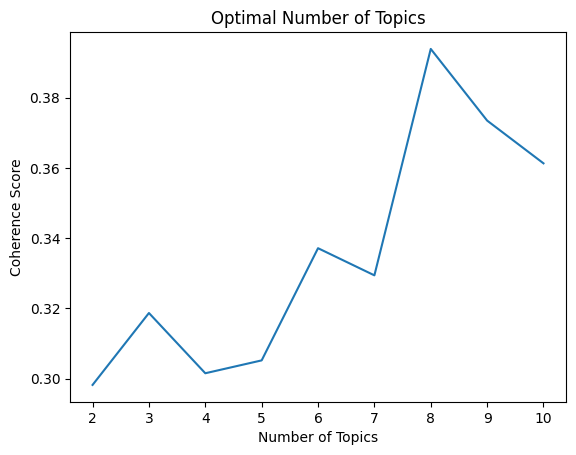

In [57]:
topic_range = range(2, 11)
coherence_scores = []
dictionary = Dictionary(all_tokens)

for num_topics in topic_range:
    # Train LDA
    lda = LatentDirichletAllocation(
        n_components=num_topics,
        learning_method='online',
        random_state=0
    )
    lda.fit(tf)
    

    cm = CoherenceModel(
        topics=[[tf_feature_names[i] for i in topic.argsort()[:-30 - 1:-1]] for topic in lda.components_],
        texts=all_tokens,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_scores.append(cm.get_coherence())

plt.plot(topic_range, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.show()


See which topics are associated with women

In [49]:
optimal_topics = topic_range[np.argmax(coherence_scores)]
print(f"Optimal number of topics: {optimal_topics}")

lda = LatentDirichletAllocation(
    n_components=5,
    learning_method='online',
    random_state=0
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()


target_word = "γυναίκα"


related_topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-30 - 1:-1]
    top_words = [tf_feature_names[i] for i in top_words_idx]
    if target_word in top_words:
        related_topics.append(topic_idx)

similar_words = [word for word, _ in model.wv.most_similar(target_word, topn=10)]
for word in similar_words:
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-30 - 1:-1]
        top_words = [tf_feature_names[i] for i in top_words_idx]
        if word in top_words and topic_idx not in related_topics:
            related_topics.append(topic_idx)

Optimal number of topics: 8


In [50]:
lda = LatentDirichletAllocation(n_components=optimal_topics, learning_method='online', random_state=0)
lda.fit(tf)

target_word = "γυναίκα"
related_topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_words = [tf_feature_names[i] for i in topic.argsort()[:-30 - 1:-1]]  # Top 30 words
    if target_word in top_words:
        related_topics.append(topic_idx)

if 'model' in locals():
    similar_words = [word for word, _ in model.wv.most_similar(target_word, topn=10)]
    for word in similar_words:
        for topic_idx, topic in enumerate(lda.components_):
            top_words = [tf_feature_names[i] for i in topic.argsort()[:-30 - 1:-1]]
            if word in top_words and topic_idx not in related_topics:
                related_topics.append(topic_idx)

print("Topics related to women (γυναίκα):")
for topic_idx in related_topics:
    top_words = [tf_feature_names[i] for i in lda.components_[topic_idx].argsort()[:-30 - 1:-1]]
    print(f"Topic {topic_idx}: {' | '.join(top_words[:10])}")  # Show top 10 words

Topics related to women (γυναίκα):
Topic 1: εις | οποίος | ήτανε | χωριό | κεφάλι | κυνηγός | τόπος | μονάχα | τούρκοι | μος
Topic 2: εις | μονάχα | χωριό | τούτος | τούρκοι | τούρκος | ήσαν | στερα | στρατός | στρατιώτης
Topic 6: εις | οποίος | τούτος | χωριό | μονάχα | παππού | ήσαν | δια | επί | τούρκος
Topic 3: εις | ήτανε | οποίος | ταγματάρχης | πρώην | χωριό | στρατός | στερα | δηλαδή | μονάχα
Topic 5: εις | ήσαν | στρατός | επί | δια | τούρκοι | τούρκος | χωριό | υπό | πόντος
